In [1]:
import pandas as pd
import scipy as sp
# import matplotlib
# import matplotlib.colors as mcolors
import pickle 
from collections import Counter
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, to_tree, dendrogram, linkage
# import math
from scipy.spatial.distance import squareform
import numpy as np
import networkx as nx
from graspologic.match import graph_match
# from sklearn import datasets, manifold
# from matplotlib.pyplot import cm
import seaborn as sns
from adjustText import adjust_text
from graphviz import Digraph, Graph
import copy
from IPython import display



/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/graspologic/layouts/colors.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pyarrow.parquet as pq

In [3]:
from module.wegog_utils import get_ego_top_NM, prepare_nhood_graphs, perform_matching, matching_distance, df_to_graph
from module.utils import load_object

In [4]:
from module.dendrogram_utils import dendrogram_clustering
from module.gramchd.gmd import sort_adjacencies, distance_stats, perform_matching_distance
from module.gramchd.nhood import get_io_top_NM, get_io_top_M
# from src.nhood_vis import df_to_graph
from module.gramchd.new_nhood_vis import plot_two_graphs_overlay, plot_two_graphs_from_output, compute_layouts_from_cont, get_overlap_info_layout
from module.utils import get_neighbourhood, get_w_threshold

from module.denclex.dendrogram_eval import get_clustering_stats, cluster_purity_test
from module.denclex.dendrograms_plotting import generate_cluster_evolution, get_cluster_evolution

In [ ]:
datadate = '20231124'
save_things = False

In [6]:
vnc_edges = pd.read_csv(f'../../data/vnc/{datadate}_data/manc_edges_{datadate}.csv', index_col=0)

vnc_edges = vnc_edges.groupby(['bodyId_pre', 'bodyId_post'], as_index=False).weight.sum()
vnc_edges.rename(columns={'bodyId_pre':'pre', 'bodyId_post':'post'}, inplace=True)
vnc_meta = pd.read_csv(f'../../data/vnc/{datadate}_data/manc_meta_{datadate}.csv', index_col=0)
vnc_edges.loc[:,'attr'] = vnc_edges.weight.apply(lambda x: {'weight':x})


vnc_meta.bodyId = vnc_meta.bodyId.astype('str')

vnc_edges.pre = vnc_edges.pre.astype('str')
vnc_edges.post = vnc_edges.post.astype('str')

In [7]:
instance_dict = vnc_meta.set_index('bodyId')['instance'].to_dict()

class_dict = vnc_meta.set_index('bodyId')['class'].to_dict()

In [8]:
heminames = ['07B', '11A', '11B', '02A', '18B', '12A', '01A', '10B', '06A', \
             '06B', '19A', '21A', '03B', '23B', '12B', '13B', '05B', '20A.22A', \
             '08A', '09A']

n_ids = list(set(vnc_meta[(vnc_meta['hemilineage'].isin(heminames))].bodyId.values)) # the integers have the numpy.int64 datatype!
n_ids = sorted(n_ids)

# Enriched clusters:

In [9]:
parquet_file = pq.ParquetFile(f'../../data/vnc/{datadate}_data/14_full_vnc_gmd_slice/func_hemi_enriched_clusters_u30.parquet').read()

# parquet_file = pq.ParquetFile(f'./data/vnc/{datadate}_data/14_full_vnc_gmd_slice/func_hemi_enriched_clusters.parquet').read()

In [10]:
enriched_cluster_df = parquet_file.to_pandas()

In [11]:
clstrno = 0

In [12]:
example_cluster = enriched_cluster_df.cluster.values[clstrno]

In [13]:
post_set = set(vnc_edges[vnc_edges['pre'].isin(example_cluster)].post)

pre_set = set(vnc_edges[vnc_edges['post'].isin(example_cluster)].pre)

In [14]:
prepost_set = post_set | pre_set

In [15]:
neighbours = prepost_set - set(example_cluster)

In [16]:
# def get_io_top_M(Id, df, M):
#     '''Gets the dataframe with the top M neurons by weight, irrespective of in or out.'''
#     source, sink = df.columns[:2]

#     pre = df.query(f'{sink}==@Id')[[source, 'weight']]
#     # print(pre)
#     post = df.query(f'{source}==@Id')[[sink, 'weight']]
#     # print(post)
#     pre.set_index(source).sort_values('weight')
#     summed_prepost = post.join(pre.set_index(source), on=sink, lsuffix='_post', rsuffix='_pre', how='outer').fillna(0)#.sort_values('weight_pre', ascending=False)
#     summed_prepost.rename(columns={sink:'id'}, inplace=True)
#     summed_prepost['total_weight'] = summed_prepost['weight_post'] + summed_prepost['weight_pre']
#     return summed_prepost.sort_values('total_weight', ascending=False).iloc[:M]


In [17]:
output = pd.read_parquet(f'../../data/vnc/{datadate}_data/gmatching/vnc_ewg_gmd_M50_hemisample_slice_overlap.parquet')

In [18]:
# subset_dist_df = output[(output['id_1'].isin(example_cluster))&(output['id_2'].isin(example_cluster))]
# ind_to_id = subset_dist_df.id_1.value_counts().index.tolist() + subset_dist_df.id_2.value_counts().index.tolist()[:1]
# dist_df = output

# dist_type = 'euclidean_distance'

# method='ward'

# cond_dist = (dist_df[dist_type].values)

# Z = linkage(cond_dist, method=method) ####### linkage

# cl_gen = generate_cluster_evolution(Z=Z, targets=ind_to_id, ind_to_id=n_ids)
# _ = next(cl_gen)
# next_cluster = next(cl_gen)
# next_subset_dist_df = output[(output['id_1'].isin(next_cluster))&(output['id_2'].isin(next_cluster))]
# method='ward'
# cond_dist = next_subset_dist_df.euclidean_distance.values
# Z = linkage(cond_dist, method=method) ####### linkage


# label_dict =(vnc_meta.set_index('bodyId')['hemilineage'].astype(str) + ' ' + vnc_meta.set_index('bodyId')['instance'].astype(str)).to_dict()

# clusters = vnc_meta.groupby('hemilineage').bodyId.apply(list).values


# # dendrogram_clustering(Z=Z, labels=next_cluster, clusters=['None'], label_dict=None)
# dendrogram_clustering(Z=Z, labels=next_cluster, clusters=clusters, label_dict=label_dict)

# method='ward'
# cond_dist = subset_dist_df.euclidean_distance.values
# Z = linkage(cond_dist, method=method) ####### linkage


# label_dict =(vnc_meta.set_index('bodyId')['hemilineage'].astype(str) + ' ' + vnc_meta.set_index('bodyId')['instance'].astype(str)).to_dict()

# clusters = vnc_meta.groupby('hemilineage').bodyId.apply(list).values


# # dendrogram_clustering(Z=Z, labels=next_cluster, clusters=['None'], label_dict=None)
# dendrogram_clustering(Z=Z, labels=ind_to_id, clusters=clusters, label_dict=label_dict)


In [19]:
# M=50
# topM_id_list = {}
# for Id in example_cluster:
#     topM = get_io_top_M(Id=Id, df=vnc_edges, M=M)
#     topM_ids = topM.id.values
#     topM_id_list[Id] = topM_ids


In [20]:
instance_dict = vnc_meta.set_index('bodyId')['instance'].to_dict()

class_dict = vnc_meta.set_index('bodyId')['class'].to_dict()

In [21]:
# nhood_overlap_stats = []
# for i in range(len(example_cluster)):
#     id_1 = example_cluster[i]
#     for j in range(i+1, len(example_cluster)):
#         id_2 = example_cluster[j]

#         nhood_1 = set(topM_id_list.get(id_1))
#         nhood_2 = set(topM_id_list.get(id_2))
#         n_overlap = len(nhood_1 & nhood_2)
#         nhood_1_ct = Counter([instance_dict.get(i).split('_')[0] for i in list(topM_id_list.get(id_1))])
#         nhood_2_ct = Counter([instance_dict.get(i).split('_')[0] for i in list(topM_id_list.get(id_2))])
#         ntype_overlap_counts = nhood_1_ct & nhood_2_ct
#         ntype_overlap = Counter({key:val for key, val in ntype_overlap_counts.items() if key != 'TBD'})
#         n_ntype_overlap = sum(ntype_overlap.values())
#         # print()
#         data = {'id_1':id_1, 'id_2':id_2, 'n_overlap':n_overlap, 'n_ntype_overlap':n_ntype_overlap}
#         nhood_overlap_stats.append(data)



In [22]:
# nhood_overlap_stats_df = pd.DataFrame(nhood_overlap_stats)

In [23]:
savepath = f'../figures/07_enriched_cluster_vis/'

In [24]:
example_cluster = enriched_cluster_df.cluster.values[13]

In [25]:
len(example_cluster)

25

In [26]:
# walking_enriched = enriched_cluster_df[enriched_cluster_df['enriched'].apply(lambda x: True if 'walking' in x else False)].sort_values(['n'], ascending=[False]).query('e_num==1')


In [27]:
# uc_leg_movement_enriched = enriched_cluster_df[enriched_cluster_df['enriched'].apply(lambda x: True if 'uc_leg_movement' in x else False)].sort_values(['n'], ascending=[False]).query('e_num==1')


In [28]:
for i in range(2):
    example_cluster = enriched_cluster_df.cluster.values[i]
    
    example_edges = vnc_edges[(vnc_edges['pre'].isin(example_cluster))&(vnc_edges['post'].isin(example_cluster))].sort_values('weight')

    example_edges = example_edges[example_edges['weight']>0]

    edges = example_edges[['pre', 'post']].to_numpy()
    # weights = np.log2(example_edges.weight.to_numpy())
    weights = 4* example_edges.weight.to_numpy()/example_edges.weight.max()

    dot = Digraph(engine='neato', name=f'{i}')
    # dot.edges(edges)
    for edge, weight in zip(edges, weights):
        dot.edge(edge[0], edge[1], penwidth=str(weight))  # str() to ensure penwidth is passed as a string

    rl_dict = {'R':'#40e0d0', 'L': '#ff000042'}

    dot.attr(overlap="false", splines="true", size="50")
    for nodename in example_cluster:
        label = instance_dict.get(nodename)
        rl = label[-1]
        dot.node(nodename, label=label, style='filled', fillcolor=rl_dict.get(rl))
    # dot.render(filename=f'{savepath}enriched_cluster_{i}.png', )

In [29]:
most_diverse = enriched_cluster_df.sort_values('delta_S', ascending=False).index[0]

In [30]:
examples = enriched_cluster_df.iloc[[4,126]].index.values # 2 examples of enriched clusters

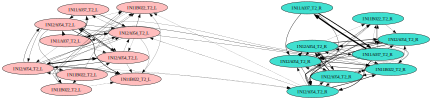

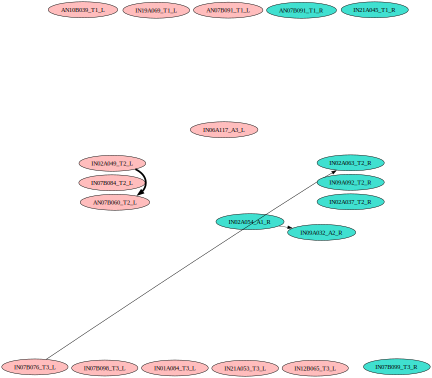

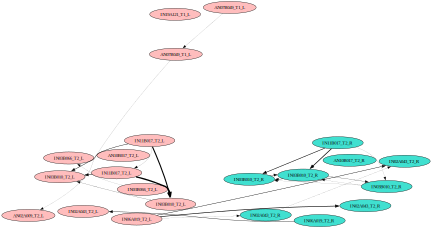

In [31]:
# example_cluster = enriched_cluster_df.iloc[8].cluster
# i = [4, 126]:

l='neato'
# for i in enriched_cluster_df.sort_values('delta_S', ascending=False).index[:5]:
for i in [*examples, most_diverse]:
    example_cluster = enriched_cluster_df.loc[i].cluster

    example_edges = vnc_edges[(vnc_edges['pre'].isin(example_cluster))&(vnc_edges['post'].isin(example_cluster))].sort_values('weight')

    example_edges = example_edges[example_edges['weight']>1]

    edges = example_edges[['pre', 'post']].to_numpy()
    # weights = np.log2(example_edges.weight.to_numpy())
    weights = 4* example_edges.weight.to_numpy()/example_edges.weight.max()

    dot = Digraph(engine=l, name=f'{i}')
    # dot.edges(edges)m
    for edge, weight in zip(edges, weights):
        dot.edge(edge[0], edge[1], penwidth=str(weight))  # str() to ensure penwidth is passed as a string

    rl_dict = {'R':'#40e0d0', 'L': '#ff000042'}
    hscale=0.3#len(example_cluster)/58
    vscale=0.5
    pos_dict= {'T3_L':('0,0!'), 'T3_R':(f'{int(5*hscale)},0!'), 
            'T2_L':(f'-{3*vscale},{int(10*hscale)}!'), 'T2_R':(f'{int(5*hscale)+(3*vscale)},{int(10*hscale)}!'),
            'T1_L':(f'0,{int(20*hscale)}!'),'T1_R':(f'{int(5*hscale)},{int(20*hscale)}!')}

    dot.attr(overlap="false", splines="true", size="6,6")
    for nodename in example_cluster:
        label = instance_dict.get(nodename)
        # (label.split('_')[-1])
        rl = label[-1]
        legneuropil = label[-4:]
        pos = pos_dict.get(legneuropil, None)
        dot.node(nodename, label=label, style='filled', fillcolor=rl_dict.get(rl), pos=pos, fontsize='')
    if save_things:
        dot.render(filename=f'{savepath}enriched_cluster_{i}')
        # dot.render(filename=f'{savepath}enriched_cluster_{i}.pdf')

    display.display_svg(dot)

In [32]:
vnc_meta[vnc_meta.instance=="IN03B010_T2_R"]

,bodyId,instance,type,pre,post,downstream,upstream,size,status,statusLabel,...,location,systematicType,source,synonyms,vfbId,inputRois,outputRois,entry_nerve,root_side,soma_neuromere
198,10244,IN03B010_T2_R,w-cHIN,128,3184,596,3184,5524487328,Roughly traced,Roughly traced,...,"[24756, 19442, 36982]",IN03B010,NaN,w-cHIN Trimarchi & Murphey 1997,VFB_jrcv07wk,"['HTct(UTct-T3)(L)', 'HTct(UTct-T3)(R)', 'WTct...","['HTct(UTct-T3)(L)', 'HTct(UTct-T3)(R)', 'WTct...",NaN,NaN,T2
204,10251,IN03B010_T2_R,w-cHIN,100,3001,484,3001,5574018785,Roughly traced,Roughly traced,...,"[24756, 20017, 37149]",IN03B010,NaN,w-cHIN Trimarchi & Murphey 1997,VFB_jrcv07wr,"['DMetaN(R)', 'HTct(UTct-T3)(L)', 'HTct(UTct-T...","['HTct(UTct-T3)(L)', 'HTct(UTct-T3)(R)', 'WTct...",NaN,NaN,T2
745,10842,IN03B010_T2_R,w-cHIN,116,1828,517,1828,3153477881,Roughly traced,Roughly traced,...,"[24756, 18992, 37126]",IN03B010,NaN,w-cHIN Trimarchi & Murphey 1997,VFB_jrcv08d6,"['HTct(UTct-T3)(L)', 'HTct(UTct-T3)(R)']","['HTct(UTct-T3)(L)', 'HTct(UTct-T3)(R)']",NaN,NaN,T2


In [33]:
for i, c in enumerate(enriched_cluster_df.cluster):

    if '10244' in c:
        print(i, c)

118 ['12608' '12035' '13233' '10147' '10251' '10842' '10244' '10481' '18583'
 '23893' '153994' '162958' '18283' '15910' '14743' '156404' '23858'
 '158785' '23023' '101499' '20478' '22740']


## Size and network density:

In [36]:
nb_name = '07_enriched_cluster_vis'

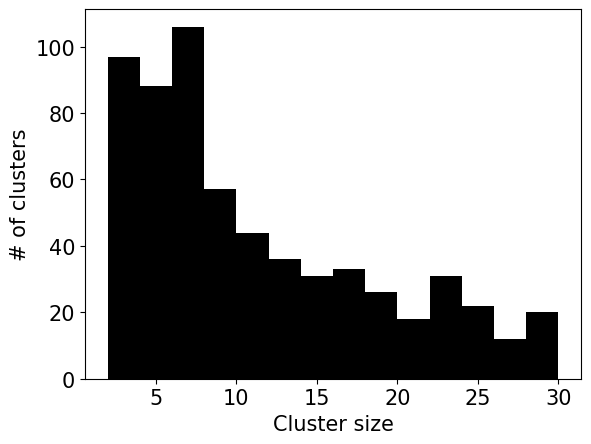

In [38]:
plt.hist(enriched_cluster_df.n.values, bins=14, color='black')
# plt.yscale('log')
plt.xlabel('Cluster size', size=15)
plt.ylabel('# of clusters', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
if save_things:
    plt.savefig(f'../figures/{nb_name}/e_cluster_number_u30.pdf', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(f'../figures/{nb_name}/e_cluster_number_u30.png', transparent=True, dpi=300, bbox_inches='tight')

plt.show()

In [41]:
neuromere_counters = []
hemisphere_counters = []
for c in enriched_cluster_df.cluster.values:
    instances = [instance_dict.get(nodename) for nodename in c]
    TBDs = len([True for i in instances if i == 'TBD'])
    ctypes = [string.split('_')[0] for string in instances if string != 'TBD']
    neuromeres = [string.split('_')[1] for string in instances if string != 'TBD']
    hemisphere = [string.split('_')[2] for string in instances if string != 'TBD']
    neuromere_counters.append(Counter(neuromeres))
    hemisphere_counters.append(Counter(hemisphere))

In [42]:
LR_balance = np.array([(c.get('L', 0), c.get('R', 0)) for c in hemisphere_counters])

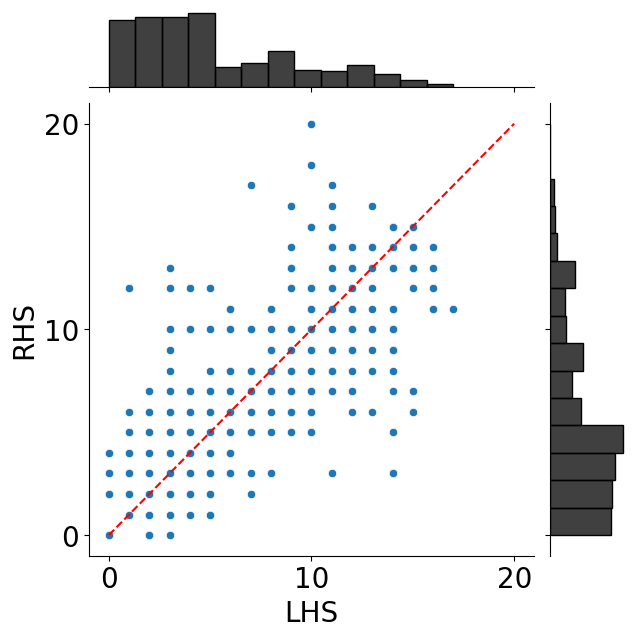

In [ ]:


g = sns.jointplot(x=LR_balance[:,0], y=LR_balance[:,1], marginal_kws=dict(fill=True, color='#000000'))
plt.xlabel('LHS', size=20)
plt.ylabel('RHS', size=20)
plt.xticks(size=20, ticks=[0,10,20])
plt.yticks(size=20, ticks=[0,10,20])
plt.plot([0, 20],[0,20], 'r--')
if save_things:
    plt.savefig(f'../figures/{nb_name}/e_cluster_sides_u30.pdf', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(f'../figures/{nb_name}e_cluster_sides_u30.png', transparent=True, dpi=300, bbox_inches='tight')
plt.show()
# g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
# g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)